In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_nw

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
comp_points = [[1., 0.5], [2.8, 1.6], [3., 0.5], [2., 0.5]]

### use 0 to make 1 oscillate

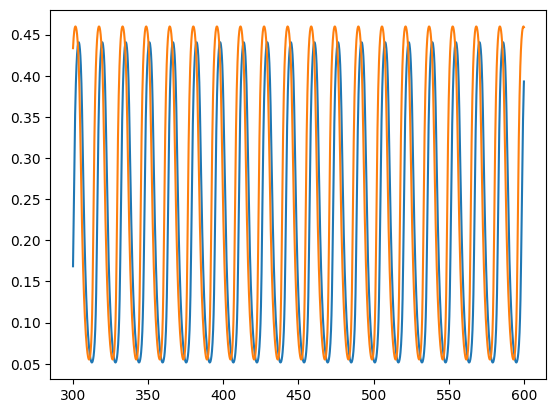

target oscillation period =  15.682258064516134
432


In [52]:
cmat = np.array( [[0., 0., 0.], [1., 0., 0.], [1., 1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0., 0.], [10., 0., 0.], [10., 10., 0.]] ) # delay from 0 to 1

N = cmat.shape[0]
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.array( [[0., 0.], [1., 0.], [0., 0.]] )

model = WCModel(Cmat=cmat, Dmat=dmat)

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params["exc_ext"] = 2.
model.params["inh_ext"] = 0.5
model.params.signalV = 1.

model.run()

peaks = scipy.signal.find_peaks(model.exc[0,100:])[0]
plist = []
for pind in range(1, len(peaks)):
    plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

period = np.mean(plist)

plt.plot(model.t[3000:6000], model.exc[0,3000:6000])
plt.plot(model.t[3000:6000], model.exc[1,3000:6000])
plt.show()

duration = 200.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( (zero_input0, zero_input0, zero_input0))
zero_control0 = np.concatenate( (zero_input,zero_input, zero_input), axis=0)[np.newaxis,:,:]
zero_control = np.vstack( (zero_control0, zero_control0, zero_control0))

results = dict()
w2_array = [1e-4]
results["controls"] =  [ [ None ], [ None ], [ None ], [ None ] ]

target_period = period
print("target oscillation period = ", target_period)
int0 = np.around( (duration - 10. * target_period) / model.params.dt, 0).astype(int)
print(int0)

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.30167565041337363
Converged in iteration 9 with cost -0.3017465557665956
Final cost : -0.3017465557665956


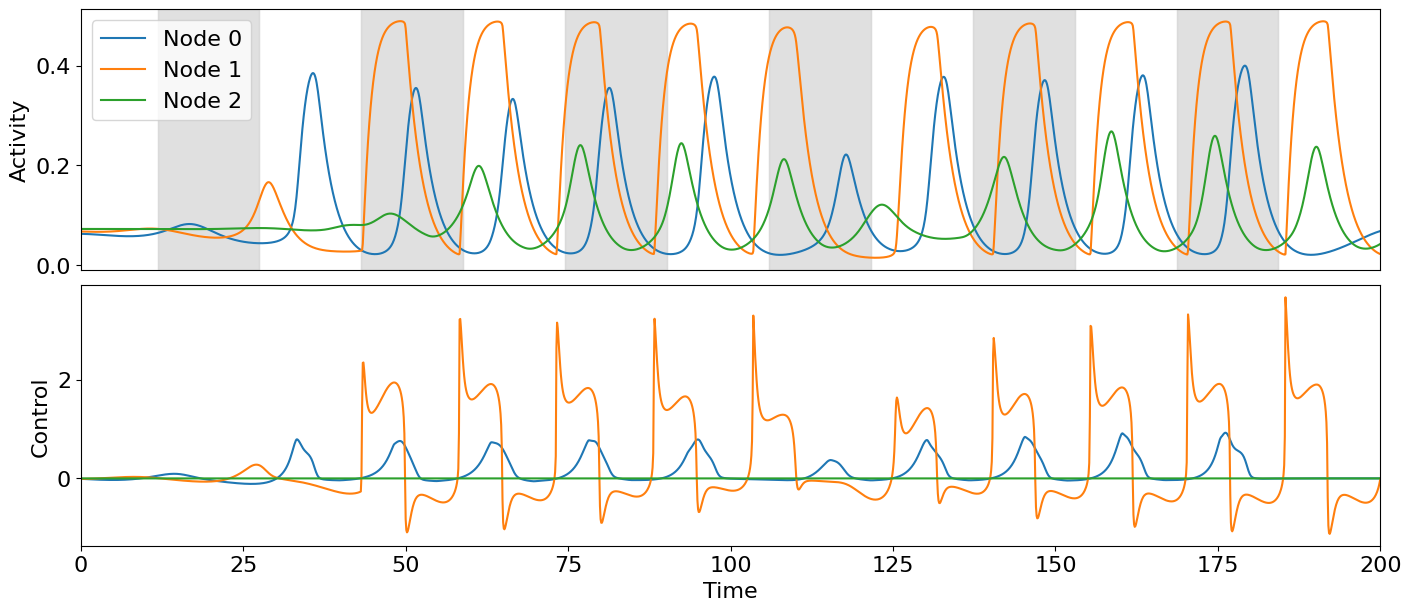

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.25709615118992624
Converged in iteration 2 with cost -0.2775864420138449
Final cost : -0.2775864420138449


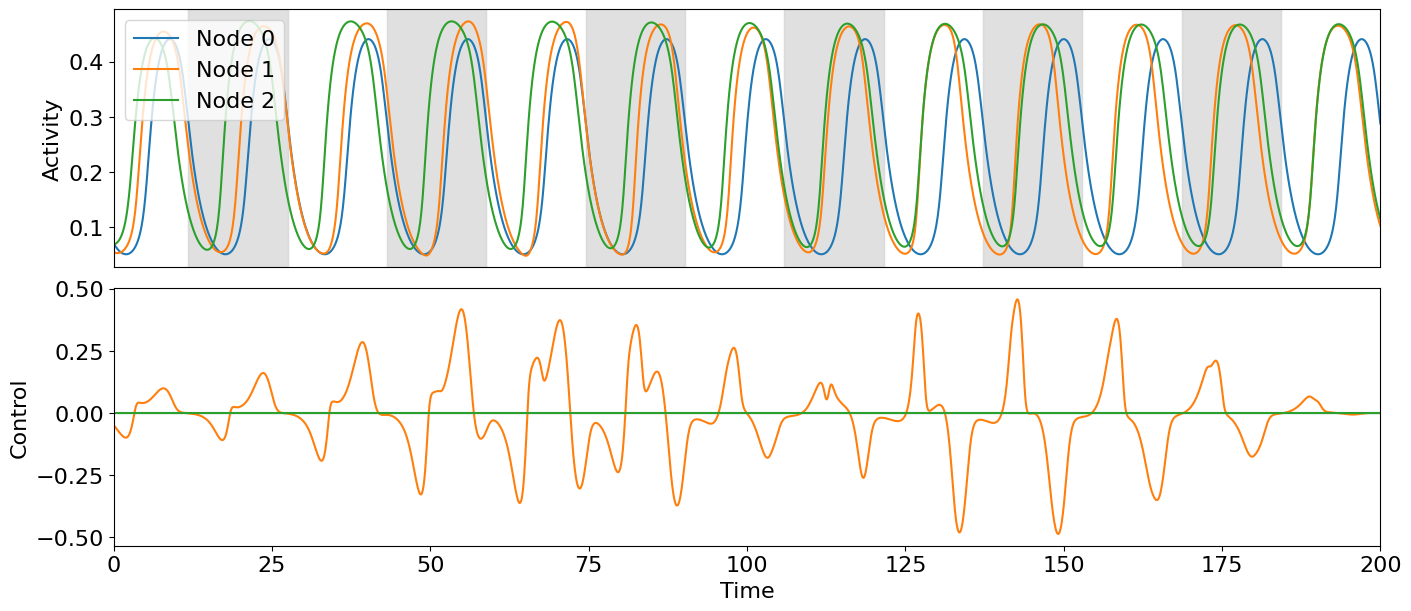

In [54]:
it = 100
pr = np.arange(0,101,10)
maxstr = 5.

for pind in [0,3]:
    p = comp_points[pind]
    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    testd = 1000.
    model.params.duration = testd
    model.run()

    e0 = model.exc[0,-1]
    e1 = model.exc[1,-1]
    e2 = model.exc[2,-1]
    i0 = model.inh[0,-1]
    i1 = model.inh[1,-1]
    i2 = model.inh[2,-1]

    nmaxdel = model.getMaxDelay()
    print("max delay = ", nmaxdel)
    e0stack = [e0] * (nmaxdel+1)
    e1stack = [e1] * (nmaxdel+1)
    e2stack = [e2] * (nmaxdel+1)
    i0stack = [i0] * (nmaxdel+1)
    i1stack = [i1] * (nmaxdel+1)
    i2stack = [i2] * (nmaxdel+1)

    model.params.duration = duration

    model.params["exc_init"] = np.array([e0stack, e1stack, e2stack])
    model.params["inh_init"] = np.array([i0stack, i1stack, i2stack])

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind][iw]) != type(None):
            model_controlled.control = results["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control)

### synchronize

In [56]:
results_sync = dict()
results_sync["controls"] =  [ [ None ], [ None ], [ None ], [ None ] ]
costmat = np.array( [[1., 0.], [1., 0.], [1., 0.]] )

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.3919450970116407
Converged in iteration 8 with cost -0.9007162797947911
Final cost : -0.9007162797947911


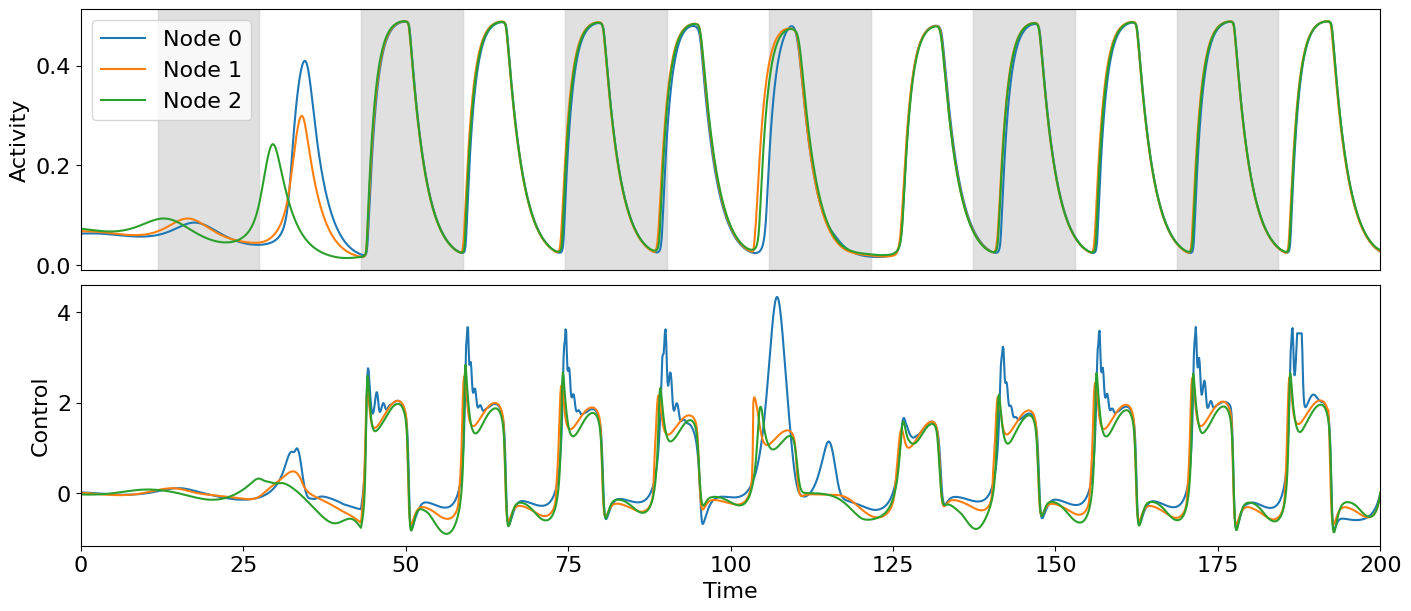

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.6512729397037351
Converged in iteration 2 with cost -0.7216456652452466
Final cost : -0.7216456652452466


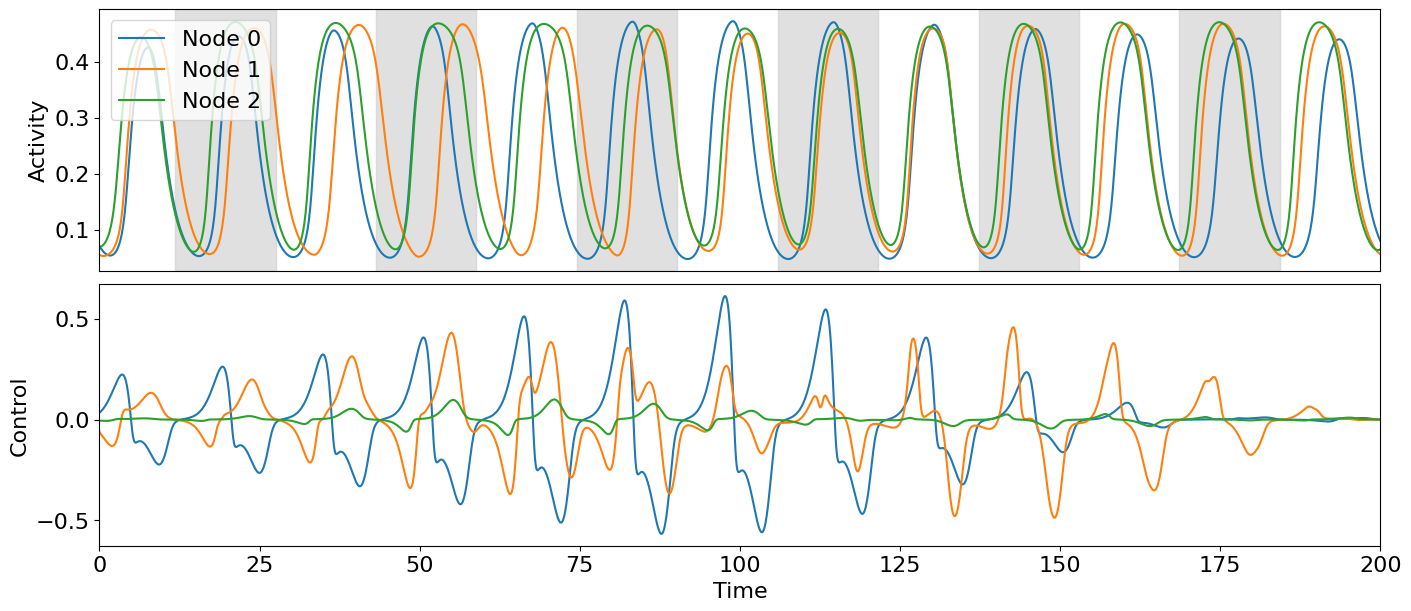

In [57]:
it = 100
pr = np.arange(0,101,10)
maxstr = 5.

for pind in [0,3]:
    p = comp_points[pind]
    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    testd = 1000.
    model.params.duration = testd
    model.run()

    e0 = model.exc[0,-1]
    e1 = model.exc[1,-1]
    e2 = model.exc[2,-1]
    i0 = model.inh[0,-1]
    i1 = model.inh[1,-1]
    i2 = model.inh[2,-1]

    nmaxdel = model.getMaxDelay()
    print("max delay = ", nmaxdel)
    e0stack = [e0] * (nmaxdel+1)
    e1stack = [e1] * (nmaxdel+1)
    e2stack = [e2] * (nmaxdel+1)
    i0stack = [i0] * (nmaxdel+1)
    i1stack = [i1] * (nmaxdel+1)
    i2stack = [i2] * (nmaxdel+1)

    model.params.duration = duration

    model.params["exc_init"] = np.array([e0stack, e1stack, e2stack])
    model.params["inh_init"] = np.array([i0stack, i1stack, i2stack])

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f_sync"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results_sync["controls"][pind][iw]) != type(None):
            model_controlled.control = results_sync["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results_sync["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period, model_controlled.control)

### phase-lock

In [58]:
results_pl = dict()
results_pl["controls"] =  [ [ None ], [ None ], [ None ], [ None ] ]

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -7.701507754600554e-18
Converged in iteration 10 with cost -0.9095137223189156
Final cost : -0.9095137223189156


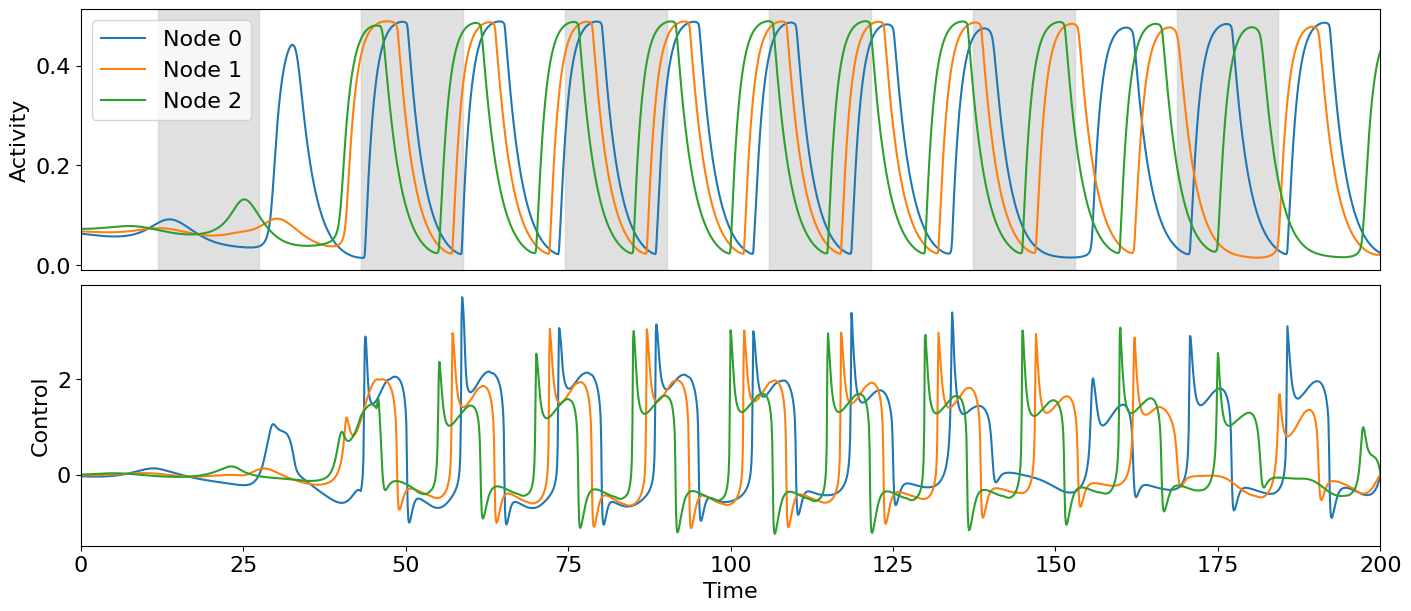

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.6458386409116534
Converged in iteration 2 with cost -0.7569773692892883
Final cost : -0.7569773692892883


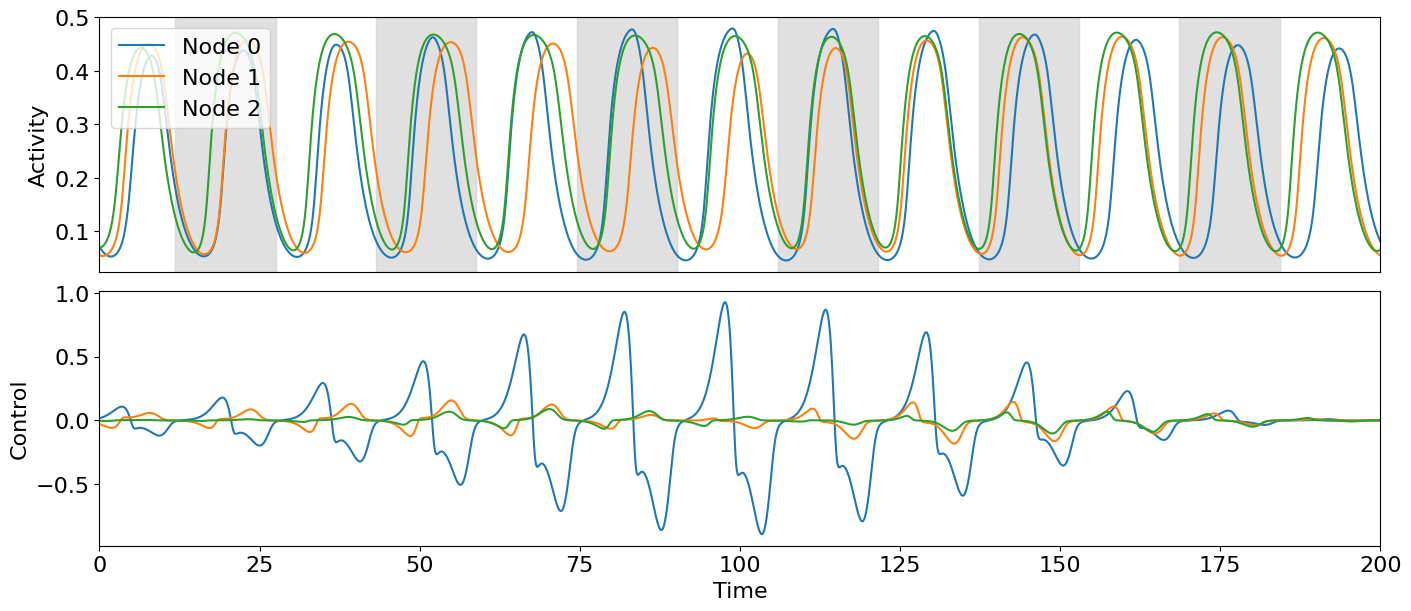

In [59]:
it = 100
pr = np.arange(0,101,10)
maxstr = 5.

for pind in [0,3]:
    p = comp_points[pind]
    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    testd = 1000.
    model.params.duration = testd
    model.run()

    e0 = model.exc[0,-1]
    e1 = model.exc[1,-1]
    e2 = model.exc[2,-1]
    i0 = model.inh[0,-1]
    i1 = model.inh[1,-1]
    i2 = model.inh[2,-1]

    nmaxdel = model.getMaxDelay()
    print("max delay = ", nmaxdel)
    e0stack = [e0] * (nmaxdel+1)
    e1stack = [e1] * (nmaxdel+1)
    e2stack = [e2] * (nmaxdel+1)
    i0stack = [i0] * (nmaxdel+1)
    i1stack = [i1] * (nmaxdel+1)
    i2stack = [i2] * (nmaxdel+1)

    model.params.duration = duration

    model.params["exc_init"] = np.array([e0stack, e1stack, e2stack])
    model.params["inh_init"] = np.array([i0stack, i1stack, i2stack])

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f_pl"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results_pl["controls"][pind][iw]) != type(None):
            model_controlled.control = results_pl["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results_pl["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period, model_controlled.control)